In [1]:
#from src.data.dataset_reader import DatasetReader
from pathlib import Path
import pandas as pd
pd.set_option('display.max_columns', None)
%load_ext autoreload
%autoreload 2
# ignore warnings
import warnings
warnings.filterwarnings('ignore')
data_folder = Path("../data/raw").resolve()

#deplay = DatasetReader(data_folder).get_data_csv('deplay.csv')


In [ ]:
#deplay_week = DatasetReader(data_folder).get_data_csv('deplay_week_treated.csv')

In [1]:
import pandas as pd
deplay_week = pd.read_csv('../data/raw/deplay_week_treated.csv')    

In [2]:
deplay_week.drop(['Unnamed: 0', 'Unnamed: 15', 'Unnamed: 17'], axis=1, inplace=True)
deplay_week['week'] = deplay_week['week'].str.replace('Week', '')
for column in deplay_week.columns:
    if deplay_week[column].dtype == 'object':
        deplay_week[column] = deplay_week[column].str.replace('€', '')
# drop this columns: 'Sales BE', 'Sales NL', 'Revenue BE', 'Revenue NL'
deplay_week.drop(['Sales BE', 'Sales NL', 'Revenue BE', 'Revenue NL'], axis=1, inplace=True)
# drop this columns Sales België	Sales Nederland
deplay_week.drop(['Sales België', 'Sales Nederland'], axis=1, inplace=True)
deplay_week['Conversion %'] = deplay_week['Conversion %'].str.replace('%', '')
# remove % sign from these columns Profit Margin	ROI
deplay_week['Profit Margin'] = deplay_week['Profit Margin'].str.replace('%', '')
deplay_week['ROI'] = deplay_week['ROI'].str.replace('%', '')
columns_to_convert = [
    'Sale price incl. VAT (Value Added Tax)', 'Sale price excl. VAT', 
    'Purchase price per piece', 'Sales', 'Revenue excl. VAT', 
    'Customer visits', 'Conversion %', 'Bol Costs', 'Shipping costs  BE', 'Shipping costs  NL', 
    'Total gross profit', 'Gross profit per piece', 'Saleable returns', 
    'Unsaleable returns', 'exchange items', 'Total returns', 
    'Total return costs', 'Total SP costs', 'Net profit', 
    'Net profit per peace', 'Profit Margin', 'ROI'
]

# Convert columns to float after cleaning the strings
for column in columns_to_convert:
    if deplay_week[column].dtype == 'object':  # Check if column contains strings
        deplay_week[column] = deplay_week[column].str.replace(',', '').str.replace('- ', '-').str.strip()
    deplay_week[column] = deplay_week[column].astype(float)

deplay_week['shipping_costs'] = deplay_week['Shipping costs  BE'] + deplay_week['Shipping costs  NL']
deplay_week.drop(['Shipping costs  BE', 'Shipping costs  NL'], axis=1, inplace=True)

In [3]:
# show duplicated rows
deplay_week[deplay_week.duplicated()].shape

(7, 23)

In [4]:
deplay_week.drop_duplicates(inplace=True)

In [ ]:
#deplay_week.to_csv('deplay_week_treated_chatgpt.csv')

# Test OOS Feature 

In [6]:
deplay_week.head()
data = deplay_week.copy()

In [7]:
cleaned_data = data.drop(columns=[ 'exchange items']).fillna(0)

In [8]:
cleaned_data.dtypes
cleaned_data['week'] = cleaned_data['week'].astype(int)

In [9]:
# drop NaN values

cleaned_data.dropna(inplace=True)

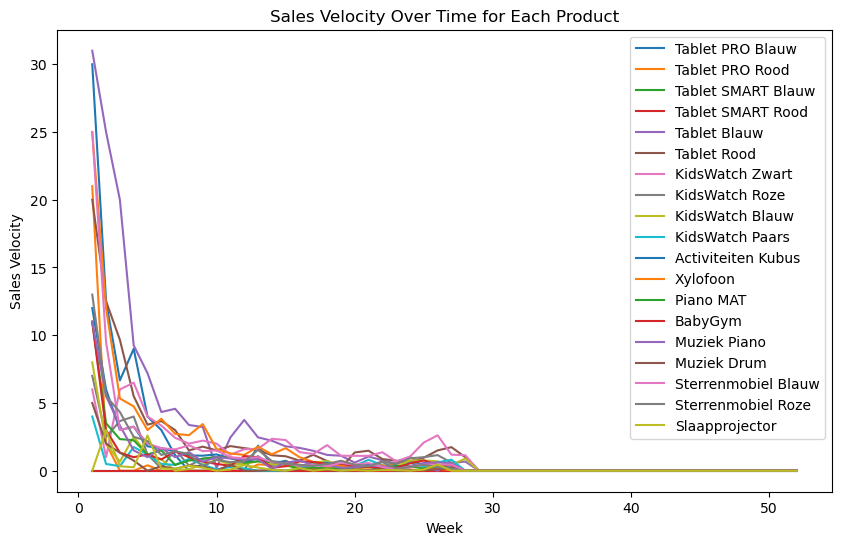

In [14]:
import matplotlib.pyplot as plt

# Feature Engineering
# Create 'Sales Velocity' = Sales/Week
cleaned_data['Sales Velocity'] = cleaned_data['Sales'] / cleaned_data['week']

# Visualize 'Sales Velocity' for each product
plt.figure(figsize=(10, 6))
for product in cleaned_data['Product'].unique():
    product_data = cleaned_data[cleaned_data['Product'] == product]
    plt.plot(product_data['week'], product_data['Sales Velocity'], label=product)

plt.xlabel('Week')
plt.ylabel('Sales Velocity')
plt.title('Sales Velocity Over Time for Each Product')
plt.legend()
plt.show()


In [15]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Initialize linear regression model
model = LinearRegression()

# Initialize a dictionary to store the model for each product
product_models = {}

# Initialize a dictionary to store the predicted 'Sales Velocity' for the next week
predicted_velocity = {}

# Loop through each product to fit a model and make a prediction
for product in cleaned_data['Product'].unique():
    product_data = cleaned_data[cleaned_data['Product'] == product]
    
    # Prepare the data for modeling
    X = product_data['week'].values.reshape(-1, 1)
    y = product_data['Sales Velocity'].values
    
    # Fit the model
    model.fit(X, y)
    
    # Store the model
    product_models[product] = model
    
    # Predict 'Sales Velocity' for the next week
    next_week = np.array([[product_data['week'].max() + 1]])
    predicted_velocity[product] = model.predict(next_week)[0]

# Show the predicted 'Sales Velocity' for the next week for each product
predicted_velocity


{'Tablet PRO Blauw': -2.3711375549908524,
 'Tablet PRO Rood': -0.8730521923007162,
 'Tablet SMART Blauw': 0.0,
 'Tablet SMART Rood': 0.0,
 'Tablet Blauw': -3.7481550147921077,
 'Tablet Rood': -2.0462477772392713,
 'KidsWatch Zwart': -0.9964382416835287,
 'KidsWatch Roze': -0.6935520288238612,
 'KidsWatch Blauw': -0.5217352854976745,
 'KidsWatch Paars': -0.28307609336493766,
 'Activiteiten Kubus': -1.0935619375308399,
 'Xylofoon': -2.2171629525369436,
 'Piano MAT': -0.8563414049336058,
 'BabyGym': -0.7432989905241718,
 'Muziek Piano': -0.9463548552033365,
 'Muziek Drum': -0.36128898029483536,
 'Sterrenmobiel Blauw': -1.7644291291592893,
 'Sterrenmobiel Roze': -1.1241958661624682,
 'Slaapprojector': -0.22583899427348153}

The predicted 'Sales Velocity' for the next week for each product is calculated.


Negative values indicate a decreasing trend; those products are not at immediate risk of going out of stock.
A value of 0 suggests no change; still, these items should be monitored.
Customer Value:
Knowing these predictions helps in planning inventory and avoiding stock-outs

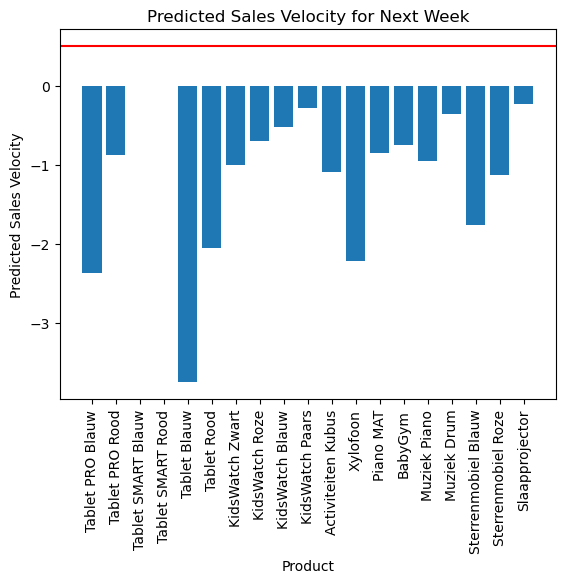

[]

In [16]:
# Thresholding: Identify items with predicted 'Sales Velocity' greater than a threshold as risky of going out of stock
# Given the data, we'll use a threshold of 0 for this PoC
threshold = 0.5

# Identify 'risky' items
risky_items = [product for product, velocity in predicted_velocity.items() if velocity > threshold]

# Visual representation
plt.bar(predicted_velocity.keys(), predicted_velocity.values())
plt.axhline(y=threshold, color='r', linestyle='-')
plt.xlabel('Product')
plt.ylabel('Predicted Sales Velocity')
plt.title('Predicted Sales Velocity for Next Week')
plt.xticks(rotation=90)
plt.show()

risky_items


The graph displays the predicted 'Sales Velocity' for the next week for each product. The red line represents the threshold.

Red Line: Threshold for identifying 'risky' items.
Risky Items:
None of the items have a predicted 'Sales Velocity' above the threshold, so currently, no items are identified as 'risky'.
Customer Value:
Inventory managers can focus on other tasks as no immediate action is required for restocking.

OOS pipeline

In [ ]:
# import libraries
from numpy import mean
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

# Redefine the classes and pipeline for clarity and integration
class DataPreprocessor(BaseEstimator, TransformerMixin):
    """
    Class for data preprocessing: handling missing values and dropping irrelevant columns.
    """
    def __init__(self, drop_columns):
        self.drop_columns = drop_columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Drop irrelevant columns
        X = X.drop(columns=self.drop_columns)
        
        # Handle missing values
        X = X.fillna(0)
        
        return X


# Feature Engineering
class AdvancedFeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['Sales Velocity'] = X['Sales'] / X['week'].replace(0, np.nan)
        X['Profit per Customer Visit'] = X['Net profit'] / X['Customer visits'].replace(0, np.nan)
        X.fillna(0, inplace=True)
        return X

# Model Training
class ModelTrainer(BaseEstimator, TransformerMixin):

    def __init__(self, model_type='linear'):
        if model_type == 'linear':
            self.model = LinearRegression()
        elif model_type == 'lgbm':
            self.model = LGBMRegressor()
        self.model_type = model_type
        self.trained_models = {}

    def fit(self, X, y, product_col):
        for product in product_col.unique():
            product_data = X[product_col == product]
            y_product = y.loc[product_data.index]
            self.model.fit(product_data, y_product)
            self.trained_models[product] = self.model
        return self

    def predict(self, X, product_col):
        predictions = {}
        for product in product_col.unique():
            product_data = X[product_col == product]
            if product in self.trained_models:
                model = self.trained_models[product]
                predictions[product] = model.predict(product_data)
        return predictions

# Main OOS Predictor Pipeline
class OOSPredictor:
    def __init__(self, threshold=0):
        self.pipeline = Pipeline([
            ('data_preprocessor', DataPreprocessor(['exchange items'])),
            ('feature_engineer', AdvancedFeatureEngineer()),
            ('model_trainer', ModelTrainer(model_type='lgbm'))
        ])
        self.threshold = threshold

    def fit(self, data):
        y = data['Sales Velocity']
        X = data.drop('Sales Velocity', axis=1)
        product_col = X['Product']
        X = pd.get_dummies(X, columns=['Product'], drop_first=True)
        self.pipeline.named_steps['model_trainer'].fit(X, y, product_col)

    def predict(self, data):
        X = data.drop('Sales Velocity', axis=1)
        product_col = X['Product']
        X = pd.get_dummies(X, columns=['Product'], drop_first=True)
        return self.pipeline.named_steps['model_trainer'].predict(X, product_col)

    def generate_alerts(self, predictions):
        alerts = {}
        for product, velocity in predictions.items():
            if velocity[-1] > self.threshold:
                alerts[product] = "At risk of going OOS"
        return alerts
    
    @staticmethod
    def evaluate(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        return mse, r2
    
    @staticmethod
    def plot_predictions(y_true, y_pred):
        plt.figure(figsize=(10, 6))
        plt.plot(y_true, label='Actual')
        plt.plot(y_pred, label='Predicted')
        plt.xlabel('Week')
        plt.ylabel('Sales Velocity')
        plt.title('Actual vs. Predicted Sales Velocity')
        plt.legend()
        plt.show()


# run pipeline
oos_predictor = OOSPredictor()
oos_predictor.fit(cleaned_data)
predictions = oos_predictor.predict(cleaned_data)
alerts = oos_predictor.generate_alerts(predictions)
# print alerts
print(alerts)
#oos_predictor.evaluate(cleaned_data['Sales Velocity'], predictions['Tablet PRO Blauw'])
#oos_predictor.plot_predictions(cleaned_data['Sales Velocity'], predictions['Tablet PRO Blauw'])

In [ ]:
# instanciate OOSPredictor with model_type='lgbm'


In [ ]:


true_values_for_tablet_pro_blauw = cleaned_data[cleaned_data['Product'] == 'Tablet PRO Blauw']['Sales Velocity']


In [ ]:
mse, r2 = oos_predictor.evaluate(true_values_for_tablet_pro_blauw, predictions['Tablet PRO Blauw'])

In [ ]:
print(f'MSE: {mse}')
print(f'R2: {r2}')

In [ ]:
predictions['Tablet PRO Blauw']
true_values_for_tablet_pro_blauw

In [ ]:
oos_predictor.plot_predictions(true_values_for_tablet_pro_blauw, predictions['Tablet PRO Blauw'])

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(cleaned_data['week'], cleaned_data['Sales'], marker='o', color='blue')
plt.title('Sales Trend Over Weeks')
plt.xlabel('Week')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

In [ ]:
sales = cleaned_data['Sales'].values

In [10]:
# import libraries
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
# new approach
df = cleaned_data.copy()

# Feature Engineering
df['Sales_lag1'] = df['Sales'].shift(1)
df['Sales_rate_of_change'] = df['Sales'].pct_change()
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

# Filling NaN values after creating lag and rate of change features
df.fillna(0, inplace=True)

# Splitting data: Using the first 4 weeks for training and the 5th week for testing
train = df[df['week'] < 5]
test = df[df['week'] == 5]

# Feature columns and target column
features = ['Sales_lag1', 'Sales_rate_of_change']
target = 'Sales'

# Model Training
model = LinearRegression()
model.fit(train[features], train[target])

# Predicting on the test set
test['Predicted_Sales'] = model.predict(test[features])

# MAE Calculation
mae = mean_absolute_error(test[target], test['Predicted_Sales'])

future_weeks = 4

# Create a DataFrame to store predicted sales for upcoming weeks
future_df = pd.DataFrame({
    'week': range(max(df['week']) + 1, max(df['week']) + 1 + future_weeks),
    'Sales_lag1': [df['Sales'].iloc[-1]] + [0] * (future_weeks - 1),
    'Sales_rate_of_change': [df['Sales_rate_of_change'].iloc[-1]] + [0] * (future_weeks - 1)
})
future_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Predicting sales for each future week
predicted_sales = []
for i in range(future_weeks):
    future_df['Predicted_Sales'] = model.predict(future_df[features])
    predicted_sales.append(future_df['Predicted_Sales'].iloc[i])
    
    # Update for next prediction
    if i < future_weeks - 1:
        future_df['Sales_lag1'].iloc[i + 1] = future_df['Predicted_Sales'].iloc[i]
        if future_df['Sales_lag1'].iloc[i] != 0:
            future_df['Sales_rate_of_change'].iloc[i + 1] = (future_df['Predicted_Sales'].iloc[i] - future_df['Sales_lag1'].iloc[i]) / future_df['Sales_lag1'].iloc[i]
        else:
            future_df['Sales_rate_of_change'].iloc[i + 1] = 0  # Or any other value that makes sense in your context


# Add the predicted sales to the future_df
future_df['Predicted_Sales'] = predicted_sales

# Establishing Stock Threshold
critical_stock_threshold = df['Sales'].mean()

# Identifying Potential OOS Weeks
future_df['Potential_OOS'] = future_df['Predicted_Sales'] > critical_stock_threshold

# Extracting potential OOS weeks
potential_oos_weeks = future_df[future_df['Potential_OOS']]['week'].tolist()

potential_oos_weeks

[53, 54, 55, 56]

In [11]:
from datetime import datetime, timedelta

# Set a base date
base_date = datetime.strptime("2023-01-01", "%Y-%m-%d")

# Convert integer weeks to datetime
df['ds'] = df['week'].apply(lambda x: base_date + timedelta(weeks=x-1))

# Now the 'ds' column is in datetime format suitable for Prophet

15:22:16 - cmdstanpy - INFO - Chain [1] start processing
15:22:17 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error (MAE): 5.962618625945055
Potential Out-of-Stock Weeks: []


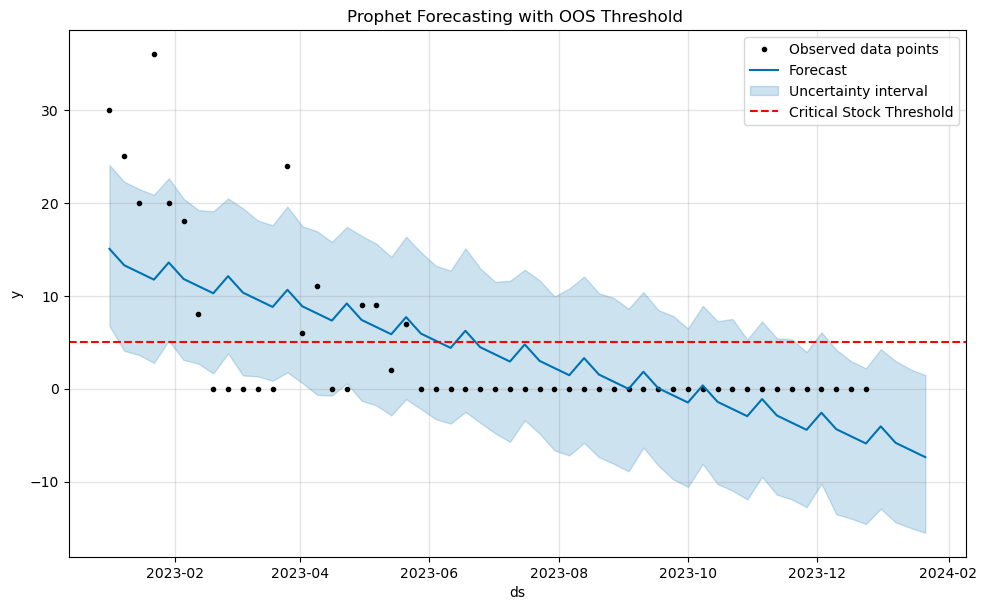

In [16]:
from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Prepare data for Prophet model#

df = cleaned_data.copy()


# Set a base date
base_date = datetime.strptime("2023-01-01", "%Y-%m-%d")

# Convert integer weeks to datetime
df['ds'] = df['week'].apply(lambda x: base_date + timedelta(weeks=x-1))

single_product_data = df[df['Product'] == 'Tablet PRO Blauw'].copy()
prophet_data = single_product_data[['ds', 'Sales']].rename(columns={'ds': 'ds', 'Sales': 'y'})

# Initialize and fit the Prophet model
prophet_model = Prophet(weekly_seasonality=True)
prophet_model.add_seasonality(name='monthly', period=4, fourier_order=3)
# add weekly seasonality
#prophet_model.add_seasonality(name='weekly', period=1, fourier_order=3)
prophet_model.fit(prophet_data)

# Make future dataframe
future = prophet_model.make_future_dataframe(periods=4, freq='W')

# Forecast
forecast = prophet_model.predict(future)

# Extracting the forecasted values for the test period and future weeks
forecasted_sales = forecast['yhat'][-4:].reset_index(drop=True)

# MAE Calculation
mae_prophet = mean_absolute_error(df['Sales'].iloc[-4:], forecasted_sales[:4])
print(f"Mean Absolute Error (MAE): {mae_prophet}")

# Establishing Stock Threshold
critical_stock_threshold = df['Sales'].mean()

# Identifying Potential OOS Weeks
future_df = pd.DataFrame({
    'week': range(max(df['week']) + 1, max(df['week']) + 1 + 4),
    'Predicted_Sales': forecasted_sales
})
future_df['Potential_OOS'] = future_df['Predicted_Sales'] > critical_stock_threshold

# Extracting potential OOS weeks
potential_oos_weeks = future_df[future_df['Potential_OOS']]['week'].tolist()
print(f"Potential Out-of-Stock Weeks: {potential_oos_weeks}")

# Plotting the forecast against actual values
fig = prophet_model.plot(forecast)
plt.axhline(y=critical_stock_threshold, color='r', linestyle='--', label='Critical Stock Threshold')
plt.title('Prophet Forecasting with OOS Threshold ')
plt.legend()
plt.show()


Text(0.5, 1.0, 'Sales Distribution')

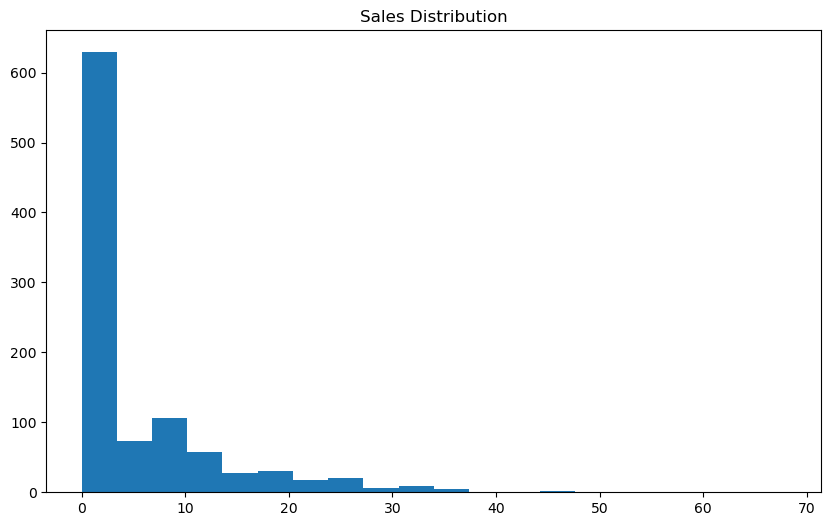

In [17]:
# plot sales distribution 
plt.figure(figsize=(10, 6))
plt.hist(df['Sales'], bins=20)
plt.title('Sales Distribution')


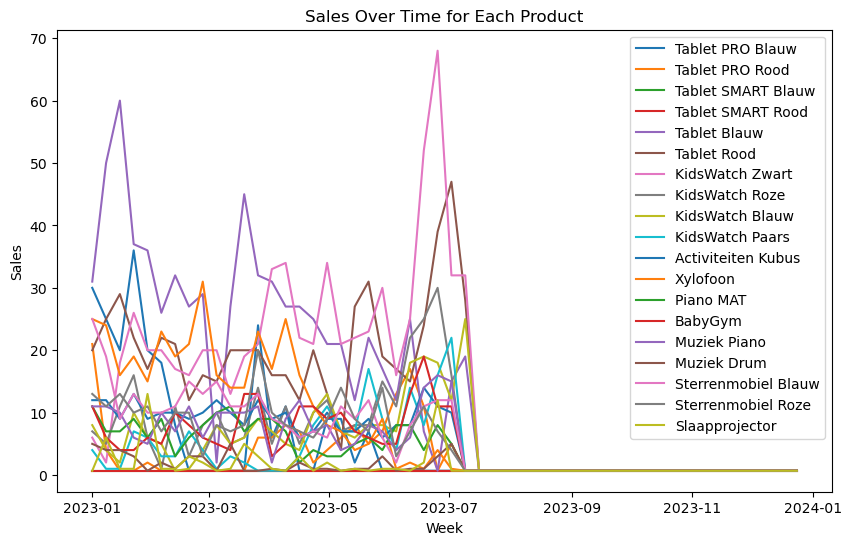

In [62]:
# Sale price excl. VAT == 0
df[df['Sale price excl. VAT'] == 0]
# plot sales for every product by week
plt.figure(figsize=(10, 6))
for product in df['Product'].unique():
    product_data = df[df['Product'] == product]
    plt.plot(product_data['ds'], product_data['Sales'], label=product)

plt.xlabel('Week')
plt.ylabel('Sales')
plt.title('Sales Over Time for Each Product')
plt.legend()
plt.show()




In [5]:
# revised apporach

from prophet import Prophet
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# 1. Prepare data for Prophet model
df = cleaned_data.copy()
df['ds'] = df['week'].apply(lambda x: datetime.strptime("2023-01-01", "%Y-%m-%d") + timedelta(weeks=x-1))

# log transfomation
df['Log_Sales'] = np.log1p(df['Sales'])

# 2. Initialize and fit the Prophet model for single product
single_product_data = df[df['Product'] == 'Tablet PRO Blauw'].copy()
prophet_data = single_product_data[['ds', 'Sales']].rename(columns={'ds': 'ds', 'Sales': 'y'})

# Replace zeros with product-specific median
#product_median = prophet_data['y'].median()
#print(f"Product Median: {product_median}")
#prophet_data['y'].replace(0, product_median, inplace=True)
non_zero_median = df[(df['Product'] == 'Tablet PRO Blauw') & (df['Sales'] > 0)]['Sales'].median()
prophet_data['y'].replace(0, non_zero_median, inplace=True)

# Fit the model
prophet_model = Prophet(weekly_seasonality=True, yearly_seasonality=False, daily_seasonality=False)
#prophet_model.add_country_holidays(country_name='US')  # Add holidays
prophet_model.fit(prophet_data)

# 3. Make future dataframe
future = prophet_model.make_future_dataframe(periods=4, freq='W')

# 4. Forecast
forecast = prophet_model.predict(future)

#forecasted_sales = np.expm1(forecast['yhat'])

# 5. MAE Calculation
mae_prophet = mean_absolute_error(np.expm1(prophet_data['y'].iloc[-4:]), forecast['yhat'].iloc[-4:])
print(f"Mean Absolute Error (MAE): {mae_prophet}")

# 6. Establishing Stock Threshold using 75th percentile
critical_stock_threshold = prophet_data['y'].quantile(0.75)

# 7. Identifying Potential OOS Weeks
future_df = pd.DataFrame({
    'week': range(max(df['week']) + 1, max(df['week']) + 1 + 4),
    'Predicted_Sales': forecast['yhat'][-4:].values
})
future_df['Potential_OOS'] = future_df['Predicted_Sales'] > critical_stock_threshold

# 8. Extract potential OOS weeks
potential_oos_weeks = future_df[future_df['Potential_OOS']]['week'].tolist()
print(f"Potential Out-of-Stock Weeks: {potential_oos_weeks}")


# 9. Plotting: Use the original forecast DataFrame
fig = prophet_model.plot(forecast)
plt.axhline(y=critical_stock_threshold, color='r', linestyle='--', label='Critical Stock Threshold')  # Reverse transform the threshold
plt.title('Prophet Forecasting with OOS Threshold')
plt.legend()
plt.show()


# 10. Alert System for OOS
alert_items = future_df[future_df['Potential_OOS']]['week'].tolist()
if len(alert_items) > 0:
    print(f"ALERT: Potential Out-of-Stock for weeks {alert_items}")
else:
    print("No OOS Alert")







/Users/servandodavidtorresgarcia/miniconda3/envs/prophet/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


NameError: name 'cleaned_data' is not defined

In [52]:
# Calculate rate of change in Sales
df['Sales_RoC'] = df.groupby('Product')['Sales'].pct_change() * 100  # in percentage

# Establish a threshold for 'Risky' based on rate of change; here, I arbitrarily choose 50%
risk_threshold = 50

# Identify 'Risky' items
risky_items_df = df[df['Sales_RoC'] > risk_threshold]
risky_items = risky_items_df['Product'].unique().tolist()

if len(risky_items) > 0:
    print(f"ALERT: Risky items based on high rate of change in sales: {risky_items}")
else:
    print("No Risky Items Alert")


ALERT: Risky items based on high rate of change in sales: ['Tablet PRO Blauw', 'Tablet PRO Rood', 'Tablet Blauw', 'Tablet Rood', 'KidsWatch Zwart', 'KidsWatch Roze', 'KidsWatch Blauw', 'KidsWatch Paars', 'Activiteiten Kubus', 'Xylofoon', 'Piano MAT', 'BabyGym', 'Muziek Piano', 'Muziek Drum', 'Sterrenmobiel Blauw', 'Sterrenmobiel Roze', 'Slaapprojector']


In [53]:
df.head()

,Product,week,Sale price incl. VAT (Value Added Tax),Sale price excl. VAT,Purchase price per piece,Sales,Revenue excl. VAT,Customer visits,Conversion %,Bol Costs,Total gross profit,Gross profit per piece,Saleable returns,Unsaleable returns,Total returns,Total return costs,Total SP costs,Net profit,Net profit per peace,Profit Margin,ROI,shipping_costs,ds,Log_Sales,Sales_RoC
0,Tablet PRO Blauw,1,180.00,148.76,85.23,30.0,4462.74,251.0,11.95,359.70,1350.24,45.01,0.0,9.0,9.0,791.01,0.0,559.23,18.64,12.53,21.87,195.90,2023-01-01,3.433987,NaN
1,Tablet PRO Blauw,2,184.00,152.07,85.23,25.0,3801.74,949.0,2.63,304.76,1209.33,48.37,0.0,10.0,10.0,878.90,0.0,330.43,13.22,8.69,15.51,156.90,2023-01-08,3.258097,-16.666667
2,Tablet PRO Blauw,3,184.00,152.07,85.23,20.0,3041.40,975.0,2.05,243.80,961.90,48.09,0.0,5.0,5.0,439.45,0.0,522.45,26.12,17.18,30.65,131.10,2023-01-15,3.044522,-20.000000
3,Tablet PRO Blauw,4,184.00,152.07,85.23,36.0,5474.49,796.0,4.52,438.85,1752.41,48.68,0.0,7.0,7.0,615.23,0.0,1137.18,31.59,20.77,37.06,214.95,2023-01-22,3.610918,80.000000
4,Tablet PRO Blauw,5,188.25,155.58,85.23,20.0,3111.61,672.0,2.98,248.05,1040.76,52.04,0.0,5.0,5.0,439.45,0.0,601.31,30.07,19.32,35.28,118.20,2023-01-29,3.044522,-44.444444


Text(0.5, 1.0, 'Sales Distribution')

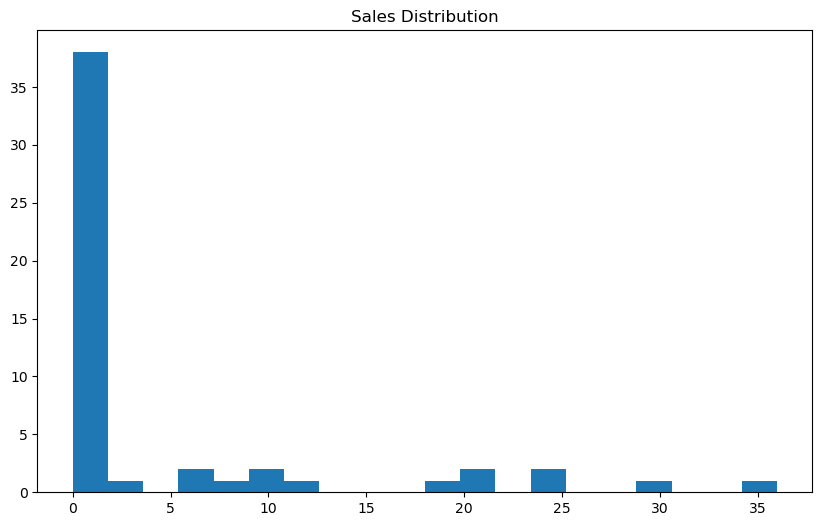

In [49]:
# plot sales distribution of single_product_data
plt.figure(figsize=(10, 6))
plt.hist(single_product_data['Sales'], bins=20)
plt.title('Sales Distribution')

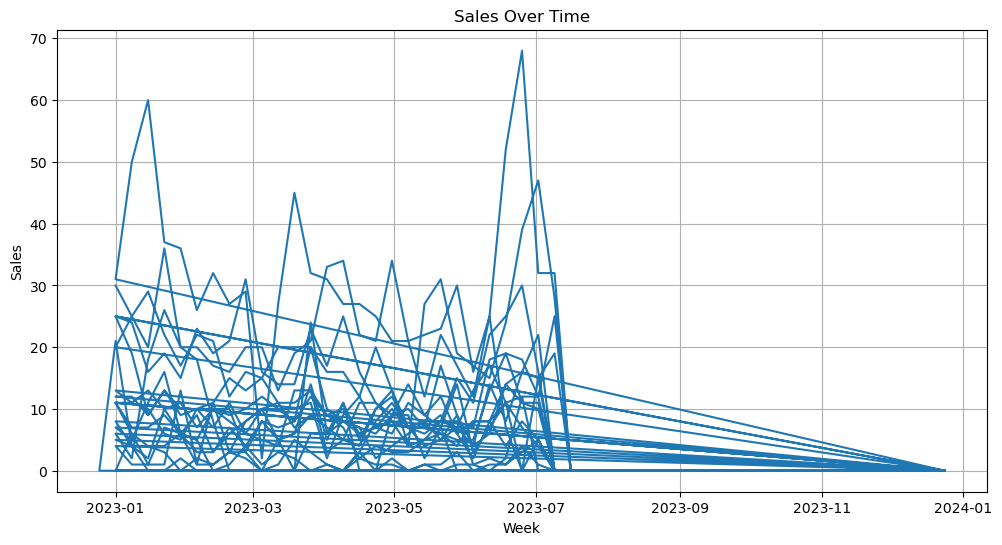

In [57]:
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['Sales'], )
plt.title("Sales Over Time")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


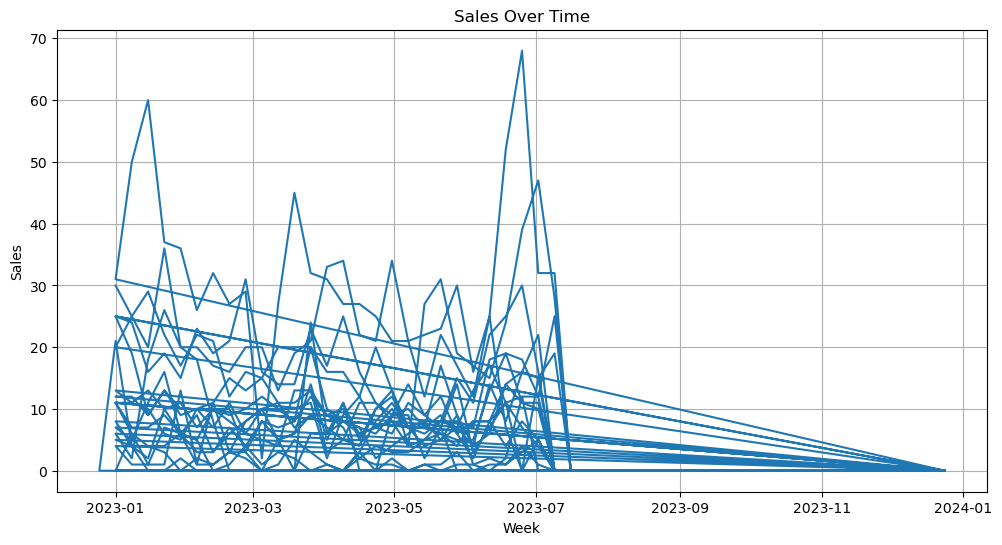

In [58]:
# plot sales over time 
plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['Sales'], )
plt.title("Sales Over Time")
plt.xlabel("Week")
plt.ylabel("Sales")
plt.grid(True)
plt.show()


<Axes: xlabel='ds'>

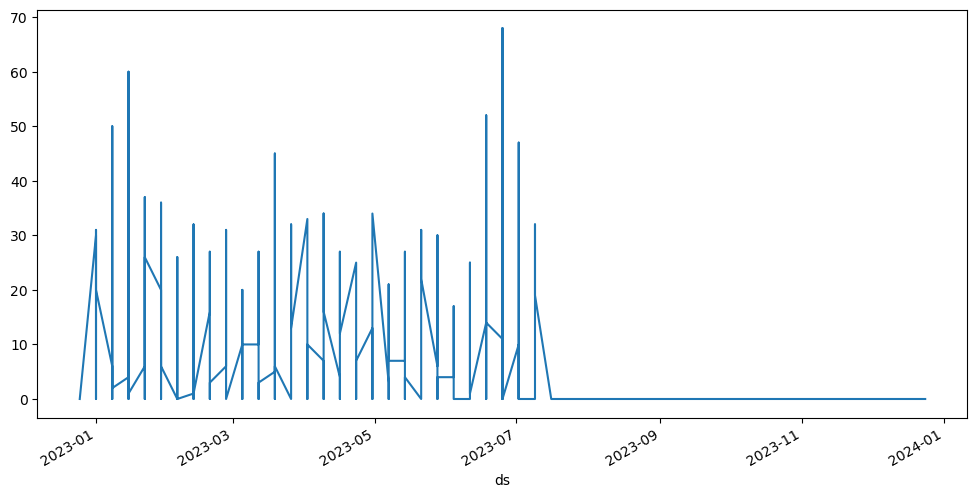

In [65]:
df.set_index('ds')['Sales'].plot(figsize=(12, 6))